In [20]:
import json
import copy

import numpy as np
from scipy import optimize
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.gridspec as gridspec

from defect_thermodynamics import DefectThermodynamics

from jax import grad, jit, vmap
import nlopt
import nevergrad as ng

import warnings
warnings.filterwarnings(action='once')


light_grey = '#EEEEEE'
lighter_grey = '#F5F5F5'
markers = ['d', 'P', 'o']
colors = ['#74a9cf','#0570b0','#023858']
font = {'size': 16}
linewidth = 2
markersize = 2

In [22]:
def defect_label_formatter(defect_string):
    comps = defect_string.split('_')
    new_string = f'{comps[0]}$_\mathrm{{{comps[1]}}}^{{{comps[2]}}}$'
    return new_string


# Reproduce Figures 2 and 3 from [PRB 90, 245202 (2014)]

                V_Cd          V_Te     Cd_Te         Te_Cd        Cd_int  \
charge                                                                     
-3      0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
-2      4.418313e-21  0.000000e+00  0.000000  4.190963e-45  0.000000e+00   
-1      1.964988e-23  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
 0      3.738794e-09  0.000000e+00  0.000000  1.356434e-01  1.666323e-32   
 1      0.000000e+00  0.000000e+00  0.000000  9.733591e+01  0.000000e+00   
 2      0.000000e+00  2.144321e+24  0.004173  5.803190e+15  1.689921e+11   
 3      0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   
 4      0.000000e+00  0.000000e+00  0.000000  0.000000e+00  0.000000e+00   

              Te_int  
charge                
-3      0.000000e+00  
-2      0.000000e+00  
-1      0.000000e+00  
 0      5.504579e-09  
 1      0.000000e+00  
 2      5.012123e+07  
 3      0.000000e+00  
 4      0.000000e+00  


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


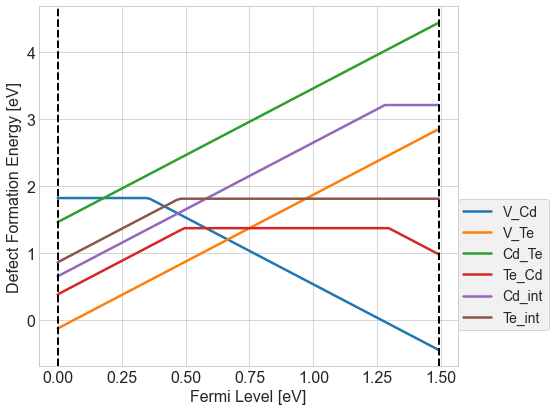

In [60]:
extrinsic_defects  = [#"V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                      "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                      "As_Te", 
                      "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                      "Cu_Cd", "Cu_int", "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

test_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                             excluded_defects=extrinsic_defects)

chem_pots = [-1.17, 0, 0, 0, 0, 0]
plt = test_thermo.formation_energy_plot(chem_pots)

dfdc = test_thermo.defect_concentrations_dataframe(chem_pots, 0.0, 300) 
print(dfdc)

In [22]:
print( dfdc['Te_int+Te_Cd'].loc[0] / (dfdc['Te_int'].loc[0] * dfdc['Te_Cd'].loc[0]) )
print(np.exp(1.45/(8.617e-5 * 300)) * 8*35.61*1e-24)


list(map(lambda x: x.split("+"), dfdc.columns))

651.0315753155675
652.4270172781485


[['V_Cd'],
 ['V_Te'],
 ['Cd_Te'],
 ['Te_Cd'],
 ['Cd_int'],
 ['Te_int'],
 ['V_Cd', 'Te_Cd'],
 ['Te_int', 'Te_int'],
 ['Te_int', 'Te_Cd']]

In [6]:
dffe = test_thermo.formation_energies_dataframe(chem_pots, 0.0)
print(dffe)
print(dffe['V_Cd+Te_Cd'].loc[-2] - dffe['V_Cd'].loc[-2] - dffe['Te_Cd'].loc[0])

print(dffe['Te_int+Te_int'].loc[2] - dffe['Te_int'].loc[2] - dffe['Te_int'].loc[0])
print(dffe['Te_int+Te_Cd'].loc[0] - dffe['Te_int'].loc[0] - dffe['Te_Cd'].loc[0])

        V_Cd  V_Te  Cd_Te  Te_Cd  Cd_int  Te_int  V_Cd+Te_Cd  Te_int+Te_int  \
charge                                                                        
-3       NaN   NaN    NaN    NaN     NaN     NaN         NaN            NaN   
-2      2.55   NaN    NaN   3.98     NaN     NaN        4.27            NaN   
-1       NaN   NaN    NaN    NaN     NaN     NaN         NaN            NaN   
 0      1.84   NaN    NaN   1.39    3.19    1.81        2.48            NaN   
 1       NaN   NaN    NaN    NaN     NaN     NaN         NaN           2.60   
 2       NaN -0.13   1.44   0.40    0.63    0.86         NaN           1.25   
 3       NaN   NaN    NaN    NaN     NaN     NaN         NaN           1.01   
 4       NaN   NaN    NaN    NaN     NaN     NaN         NaN           0.87   

        Te_int+Te_Cd  
charge                
-3               NaN  
-2               NaN  
-1               NaN  
 0              1.75  
 1               NaN  
 2              0.98  
 3              0.79  
 4

In [63]:
temperature = 873
final_temperature = 300
muCds = np.linspace(-1.17, 0, 100)

nholes = np.zeros(muCds.shape)
nelectrons = np.zeros(muCds.shape)
efermis = np.zeros(muCds.shape)

defect_concentrations = {
                         "V_Cd": {"0": np.zeros(muCds.shape),
                                  "-1": np.zeros(muCds.shape),
                                  "-2": np.zeros(muCds.shape)},
                         "V_Te": {"2": np.zeros(muCds.shape)},
                         "Cd_Te": {"2": np.zeros(muCds.shape)},
                         "Te_Cd": {"0": np.zeros(muCds.shape), 
                                   "1": np.zeros(muCds.shape),
                                   "2": np.zeros(muCds.shape)},
                         "Te_int": {"0": np.zeros(muCds.shape), "2": np.zeros(muCds.shape)},
#                          "V_Cd+Te_Cd": {"0": np.zeros(muCds.shape)}, 
#                          "Te_int+Te_int": {"2": np.zeros(muCds.shape), "3": np.zeros(muCds.shape)}, 
#                          "Te_int+Te_Cd": {"0": np.zeros(muCds.shape), "2": np.zeros(muCds.shape)}
                        }

nholes_quench = np.zeros(muCds.shape)
nelectrons_quench = np.zeros(muCds.shape)
efermis_quench = np.zeros(muCds.shape)

defect_concentrations_quench = copy.deepcopy(defect_concentrations)


for i, mucd in enumerate(muCds):
    chem_pots = [mucd, 0, -1.15-mucd, 0, 0, -1]
    ef_tmp = test_thermo.solve_for_fermi_energy(chem_pots, temperature)
    h_tmp, e_tmp = test_thermo.charge_carriers(ef_tmp, temperature)
    
    df_tmp = test_thermo.defect_concentrations_dataframe(chem_pots, ef_tmp, temperature)
    for dlabel, dconc_dict in defect_concentrations.items():
        for qstate, dconc in dconc_dict.items():
            dconc[i] = df_tmp[dlabel].loc[int(qstate)]
        
    nholes[i] = h_tmp
    nelectrons[i] = e_tmp
    efermis[i] = ef_tmp
                           
    ### Quench to 300 K
    high_temp_conc = test_thermo.defect_concentrations(chem_pots, ef_tmp, temperature)
    efq_tmp = test_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, temperature)
    hq_tmp, eq_tmp = test_thermo.charge_carriers(efq_tmp, final_temperature)
    
    low_temp_conc = test_thermo.redistribute_defect_charge_states(high_temp_conc, efq_tmp, final_temperature)
    for j, (dlabel, dconc_dict) in enumerate(defect_concentrations_quench.items()):
        for qstate, dconc in dconc_dict.items():
            dconc[i] = low_temp_conc[j][int(qstate) + 3]
                          
    nholes_quench[i] = hq_tmp
    nelectrons_quench[i] = eq_tmp
    efermis_quench[i] = efq_tmp


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


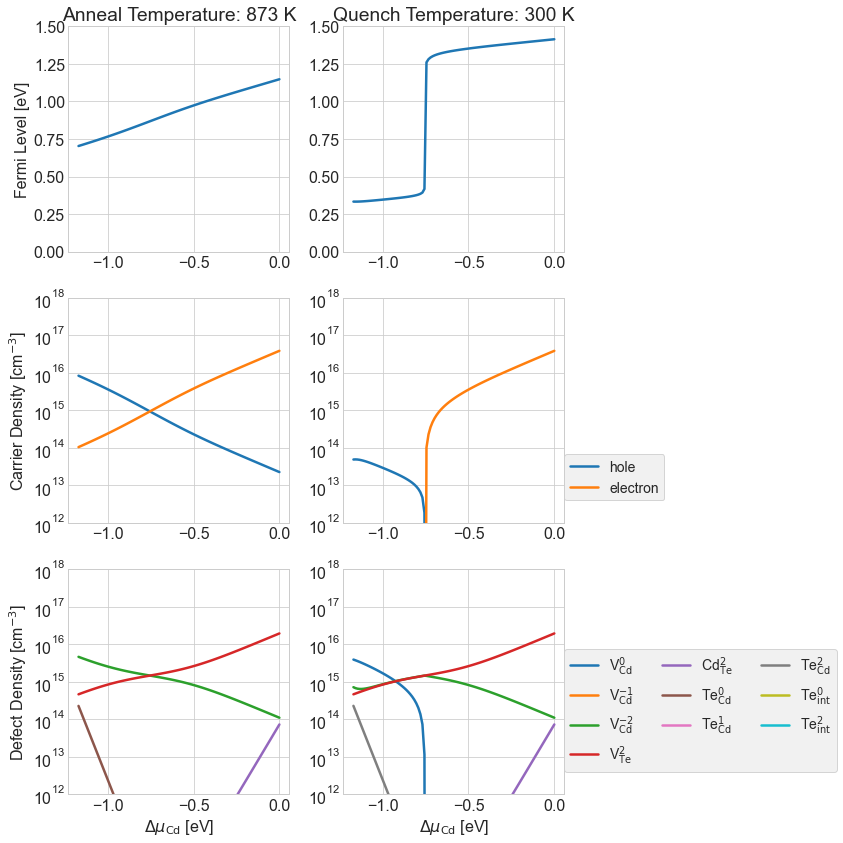

In [64]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(muCds, efermis, label=None,
                linestyle='-', linewidth=2.5)
axes[0][1].plot(muCds, efermis_quench, label=None,
                linestyle='-', linewidth=2.5)

axes[0][0].set_ylim((0.0,1.5))
axes[0][1].set_ylim((0.0,1.5))
axes[0][0].set_ylabel(r'Fermi Level [eV]')
axes[0][0].set_title(f'Anneal Temperature: {temperature} K')
axes[0][1].set_title(f'Quench Temperature: {final_temperature} K')



axes[1][0].plot(muCds, nholes, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][0].plot(muCds, nelectrons, label='electron',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nholes_quench, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nelectrons_quench, label='electron',
                linestyle='-', linewidth=2.5)

axes[1][0].set_yscale('log')
axes[1][1].set_yscale('log')

axes[1][0].set_ylim((1e12,1e18))
axes[1][1].set_ylim((1e12,1e18))

axes[1][0].set_ylabel(r'Carrier Density [cm$^{-3}$]')
axes[1][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)




for dlabel, dconc_dict in defect_concentrations.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][0].plot(muCds, dconc, label=new_label,
                        linestyle='-', linewidth=2.5)
for dlabel, dconc_dict in defect_concentrations_quench.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][1].plot(muCds, dconc, label=new_label,
                        linestyle='-', linewidth=2.5)

axes[2][0].set_yscale('log')
axes[2][1].set_yscale('log')

axes[2][0].set_ylim((1e12,1e18))
axes[2][1].set_ylim((1e12,1e18))
    
axes[2][0].set_ylabel(r'Defect Density [cm$^{-3}$]')
axes[2][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=3)

axes[2][0].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')
axes[2][1].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()



# Formation Energies of As, Cu, and Cl dopants from [JAP 118, 025102 (2015)], [APL 111, 042106 (2017)], and [JAP 119, 045104 (2016)]

,As_Te,Cl_Te,Cl_int,Cl_int_spl,Cl_Te+V_Cd,Cl_int+V_Cd,Cu_Cd,Cu_int,Cu_Cd+Cd_int,Cu_Cd+Cu_int
charge,,,,,,,,,,
-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1,1.37,NaN,1.46,NaN,2.04,2.18,0.22,NaN,3.05,2.24
0,2.06,1.99,2.07,2.05,2.70,2.78,0.84,2.18,2.70,1.59
1,2.21,1.52,NaN,1.58,NaN,NaN,NaN,1.63,2.24,2.14
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


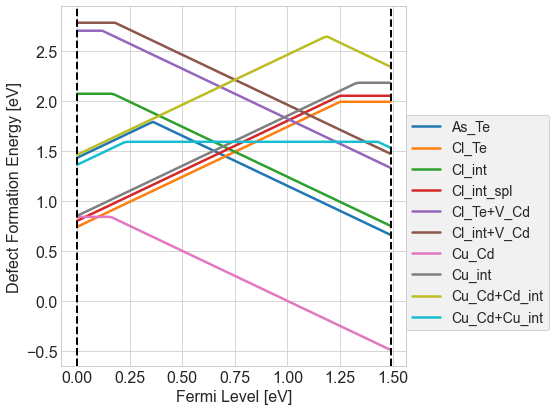

In [7]:
intrinsic_defects = ["V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int"]

test_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                             excluded_defects=intrinsic_defects)

chem_pots = [-1.15, 0, 0, -0.25, 1.53, -1.22]
plt = test_thermo.formation_energy_plot(chem_pots)

test_thermo.formation_energies_dataframe(chem_pots, 0.78) 

# Synthesis optimization from [APL 111, 042106 (2017)]

Note that the objective function used below is somewhat different to the one described [APL 111, 042106 (2017)], but the main result is the same, namely lower incorporation temperature required for more Cd-poor material in order for hole concentration and carrier lifetimes above 10^16 cm^-3 and 10 ns, respectively.  Note, however, the prior assumption in [APL 111, 042106 (2017)] that the rate limiting steps for carrier capture are from Cu defect levels, which neglects any contributions from intrinsic defect levels.

In [7]:
excluded_defects = ["V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                    "As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                             excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    NCu_Cd = np.sum(low_temp_conc[0])
    NCu_int = np.sum(low_temp_conc[1])
    
    Bn = 2.55e-10
    Bp = 6.82e-10
    capture_rates = [Bn * NCu_Cd, Bp * NCu_int]
    total_lifetime = 1/np.sum(capture_rates)
    
    return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime

def objective_func(x, args):
    [muCd, muCu] = x
    anneal_temp = args[0]
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, 0]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)
#     print(x)
#     print(total_lifetime, hq)
#     print(10*"-")
    
    return (np.abs(1-total_lifetime/1e-8) + np.abs(1-hole_conc/1e16))
#     return np.abs(1e17 - np.sum(low_temp_conc))


cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (None, 0))

anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

x_init = [H_CdTe, 0]
for i, ann_temp in enumerate(anneal_temps):
    opt = optimize.minimize(objective_func, x_init, args=[ann_temp], 
                            method='SLSQP', options={'ftol':1e-10},
                            bounds=bnds, constraints=cons)
    x_init = opt.x
    
    Cd_chem_pots[i] = opt.x[0]
    Cu_chem_pots[i] = opt.x[1]
    
    print(f' Step {i} | temp {ann_temp} |', opt.x)
    
    chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    total_lifetimes[i] = total_lifetime
    

/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 0 | temp 400 | [-1.17 -0.25]
 Step 1 | temp 425 | [-0.92  0.  ]
 Step 2 | temp 450 | [-0.92  0.  ]
 Step 3 | temp 475 | [-0.92  0.  ]
 Step 4 | temp 500 | [-0.92  0.  ]
 Step 5 | temp 525 | [-0.92  0.  ]
 Step 6 | temp 550 | [-0.92  0.  ]
 Step 7 | temp 575 | [-0.92  0.  ]
 Step 8 | temp 600 | [-0.92  0.  ]
 Step 9 | temp 625 | [-0.92  0.  ]
 Step 10 | temp 650 | [-8.91711450e-01 -6.11803088e-14]
 Step 11 | temp 675 | [-8.49964247e-01 -4.30812737e-13]
 Step 12 | temp 700 | [-8.07963257e-01 -7.09749195e-13]
 Step 13 | temp 725 | [-7.65714378e-01 -1.71780888e-12]
 Step 14 | temp 750 | [-7.23221548e-01 -8.29106920e-12]
 Step 15 | temp 775 | [-6.80488261e-01 -1.50903379e-12]
 Step 16 | temp 800 | [-0.63751804  0.        ]
 Step 17 | temp 825 | [-0.59431824  0.        ]
 Step 18 | temp 850 | [-0.55089722  0.        ]
 Step 19 | temp 875 | [-5.07266804e-01 -1.15463195e-13]
 Step 20 | temp 900 | [-0.46344236  0.        ]
 Step 21 | temp 925 | [-4.19442474e-01 -2.37676545e-13]
 Step 22 |

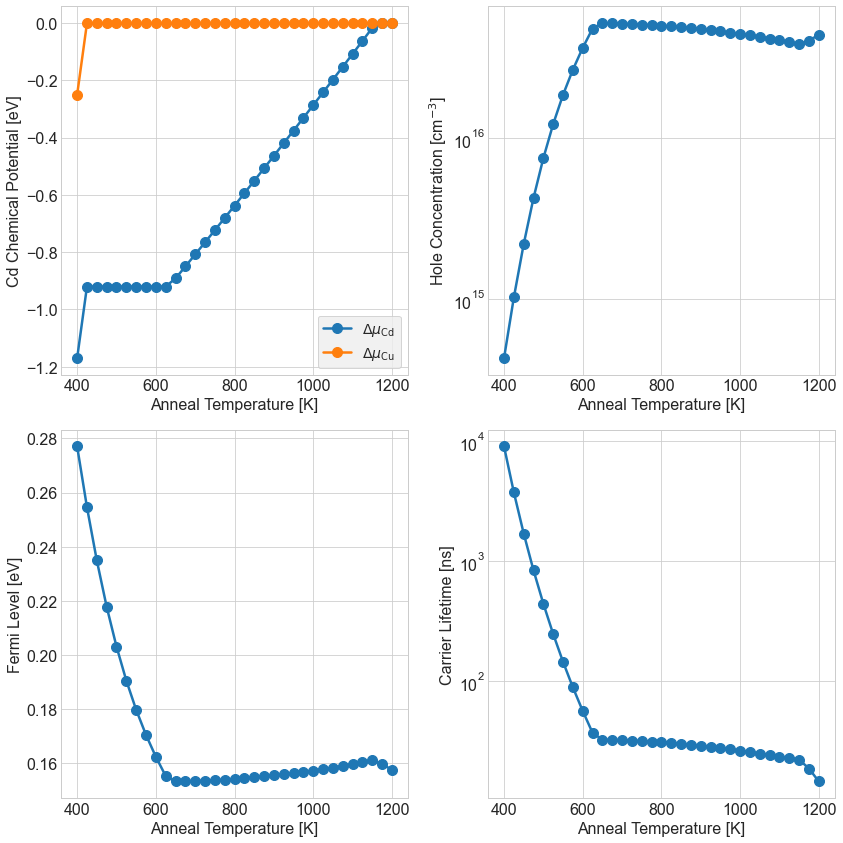

In [8]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(2,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Cd Chemical Potential [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, total_lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

## Optimize mu_Cd, mu_Cu and anneal temperature.

In [9]:
def objective_func_global(x):
    [muCd, muCu, anneal_temp] = x
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, 0]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)
    return (np.abs(1-total_lifetime/1e-8) + np.abs(1-hole_conc/1e16))



cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (None, 0), (300, 1200))
x_init = [H_CdTe, -1, 800]
# optg = optimize.minimize(objective_func_global, x_init, 
#                         method='SLSQP', options={'ftol': 1e-10},
#                         bounds=bnds, constraints=cons)

minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, 
                    "constraints": cons, "options":{'ftol': 1e-10}}
optg = optimize.basinhopping(objective_func_global, x_init, minimizer_kwargs=minimizer_kwargs,
                             niter=100)

print(optg)

/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


                        fun: 3.8053826109719866
 lowest_optimization_result:      fun: 3.8053826109719866
     jac: array([-4.26968423e+00, -1.33878447e+01, -2.26497650e-04])
 message: 'Optimization terminated successfully'
    nfev: 114
     nit: 29
    njev: 28
  status: 0
 success: True
       x: array([   0.,    0., 1200.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 3131
                        nit: 100
                       njev: 736
                          x: array([   0.,    0., 1200.])


In [11]:
chem_pots = [optg.x[0], 0, H_CdTe-optg.x[0], optg.x[1], 0, 0]
final_temperature = 300

ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                  final_temperature, 
                                                                                  optg.x[2])
print("Cd chemical potential: {:.3f} [eV]".format(optg.x[0]))
print("Cu chemical potential: {:.3f} [eV]".format(optg.x[1]))
print("Anneal Temperature: {:.1f} [K]".format(optg.x[2]))
print("Fermi level: {:.3f} [eV]".format(ef))
print("Hole concentration: {:.3e} [1/cm^3]".format(hole_conc))
print("Carrier lifetime: {:.3f} [ns]".format(total_lifetime/1e-9))

Cd chemical potential: 0.000 [eV]
Cu chemical potential: 0.000 [eV]
Anneal Temperature: 1200.0 [K]
Fermi level: 0.158 [eV]
Hole concentration: 4.345e+16 [1/cm^3]
Carrier lifetime: 14.606 [ns]


/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))


## Add in intrinisic defects
Additional capture rates from [Scientific Reports 6, 21712 (2016)]

In [21]:
excluded_defects = ["As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd"]

defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    NV_Cd = np.sum(low_temp_conc[0])
    NTe_Cd = np.sum(low_temp_conc[3])
    NCu_Cd = np.sum(low_temp_conc[-4])
    NCu_int = np.sum(low_temp_conc[-3])
    
    Bn_Cd = 1.55e-11
    Bp_Cd = 1.69e-10
    Bn_Cu = 2.55e-10
    Bp_Cu = 6.82e-10
    capture_rates = [Bn_Cd * NV_Cd, Bp_Cd * NTe_Cd,
                     Bn_Cu * NCu_Cd, Bp_Cu * NCu_int]
    total_lifetime = 1/np.sum(capture_rates)
    
    return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime

def objective_func(x, args):
#     [muCd, muCu, muCl] = x
    [muCd, muCu] = x
    muCl = 0
    anneal_temp = args[0]
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)
#     print(x)
#     print(total_lifetime, hq)
#     print(10*"-")
    
#     return -((1-total_lifetime/1e-8) + (1-hole_conc/1e16))

    return ef


# cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]},
#         {'type': 'ineq', 'fun': lambda x:  H_CdCl2 - x[0] - 2*x[2]})
# bnds = ((H_CdTe, 0), (-2, 0), (-2, 0))

cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (-2, 0))

anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

# x_init = [H_CdTe, -1, -1]
x_init = [H_CdTe, 0]
for i, ann_temp in enumerate(anneal_temps):
    opt = optimize.minimize(objective_func, x_init, args=[ann_temp], 
                            method='SLSQP', options={'ftol': 1e-10},
                            bounds=bnds, constraints=cons)
    
#     minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, "args": [ann_temp],
#                         "constraints": cons, "options":{'ftol': 1e-10}}
#     opt = optimize.basinhopping(objective_func, x_init, 
#                                 minimizer_kwargs=minimizer_kwargs,
#                                 niter=100)
    x_init = opt.x
    
    Cd_chem_pots[i] = opt.x[0]
    Cu_chem_pots[i] = opt.x[1]
#     Cl_chem_pots[i] = opt.x[2]
    
    print(f' Step {i} | temp {ann_temp} |', opt.x)
    
#     chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, opt.x[2]]
    chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    total_lifetimes[i] = total_lifetime

/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 0 | temp 400 | [-1.17 -0.25]
 Step 1 | temp 425 | [-1.17 -0.25]
 Step 2 | temp 450 | [-1.17 -0.25]
 Step 3 | temp 475 | [-1.17 -0.25]
 Step 4 | temp 500 | [-1.17 -0.25]
 Step 5 | temp 525 | [-1.17 -0.25]
 Step 6 | temp 550 | [-1.17 -0.25]
 Step 7 | temp 575 | [-1.17       -0.26460022]
 Step 8 | temp 600 | [-1.17      -0.3034388]
 Step 9 | temp 625 | [-1.17       -0.34174138]
 Step 10 | temp 650 | [-1.17       -0.37958307]
 Step 11 | temp 675 | [-1.17       -0.41701627]
 Step 12 | temp 700 | [-1.17      -0.4540777]
 Step 13 | temp 725 | [-1.17       -0.49079163]
 Step 14 | temp 750 | [-1.17      -0.5271696]
 Step 15 | temp 775 | [-1.17       -0.56320626]
 Step 16 | temp 800 | [-1.17       -0.59886868]
 Step 17 | temp 825 | [-1.17      -0.6340748]
 Step 18 | temp 850 | [-1.17       -0.66865497]
 Step 19 | temp 875 | [-1.17       -0.70229057]
 Step 20 | temp 900 | [-1.17       -0.73443973]
 Step 21 | temp 925 | [-1.17       -0.76429609]
 Step 22 | temp 950 | [-1.17       -0.79087023

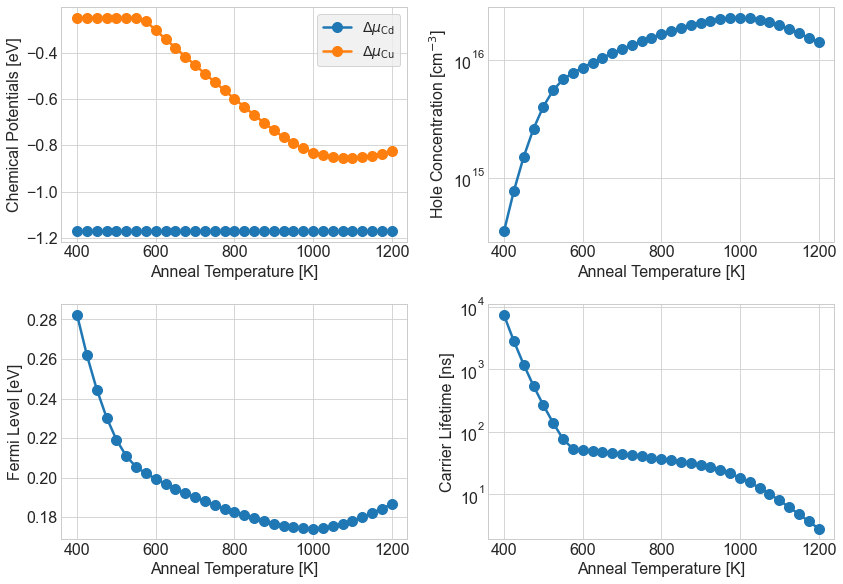

In [22]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, total_lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

In [18]:
excluded_defects = ["As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd"]

defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    return ef, hole_conc, electron_conc, low_temp_conc

def objective_func(x, grad, anneal_temp):
#     [muCd, muCu, muCl] = x
    [muCd, muCu] = x
    muCl = 0
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      anneal_temp)
    return ef


upper_bounds = [0, 0]
lower_bounds = [H_CdTe, -2.0]
cons = lambda x, grad:  H_CuTe - (H_CdTe-x[0]) - x[1]


anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

# x_init = [H_CdTe, -1, -1]
x_init = np.array([H_CdTe, -0.25])
nvar = len(x_init)
for i, ann_temp in enumerate(anneal_temps):
    
    obj_func = lambda x, grad: objective_func(x, grad, ann_temp)

    opt = nlopt.opt(nlopt.GN_ISRES, nvar)

    opt.set_min_objective(obj_func)

    local_opt = nlopt.opt(nlopt.LN_COBYLA, nvar)
    local_opt.set_ftol_rel(1e-1)

    opt.set_local_optimizer(local_opt)


    opt.set_lower_bounds(lower_bounds)
    opt.set_upper_bounds(upper_bounds)
    opt.add_inequality_constraint(cons)
    
#     opt.set_xtol_rel(1e-4)
    opt.set_maxeval(1000)

    x1 = opt.optimize(x_init)
#     x_init[:] = x1
    minf = opt.last_optimum_value()
        
    
    Cd_chem_pots[i] = x1[0]
    Cu_chem_pots[i] = x1[1]
#     Cl_chem_pots[i] = x1[2]
    
    print(f' Step {i} | temp {ann_temp} |', x1)
    
#     chem_pots = [x1[0], 0, H_CdTe-x1[0], x1[1], 0, x1[2]]
    chem_pots = [x1[0], 0, H_CdTe-x1[0], x1[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc



 Step 0 | temp 400 | [-1.16508318 -0.04029002]
 Step 1 | temp 425 | [-1.16546752 -0.02359594]
 Step 2 | temp 450 | [-1.16925341 -0.07827835]
 Step 3 | temp 475 | [-1.16575951 -0.10820455]
 Step 4 | temp 500 | [-1.15782191 -0.11207421]
 Step 5 | temp 525 | [-1.16990983 -0.20490985]
 Step 6 | temp 550 | [-1.17 -0.25]
 Step 7 | temp 575 | [-1.17 -0.25]
 Step 8 | temp 600 | [-1.17 -0.25]
 Step 9 | temp 625 | [-1.17 -0.25]
 Step 10 | temp 650 | [-1.17 -0.25]
 Step 11 | temp 675 | [-1.17 -0.25]
 Step 12 | temp 700 | [-1.17 -0.25]
 Step 13 | temp 725 | [-1.17 -0.25]
 Step 14 | temp 750 | [-1.17 -0.25]
 Step 15 | temp 775 | [-1.17 -0.25]
 Step 16 | temp 800 | [-1.17 -0.25]
 Step 17 | temp 825 | [-1.17 -0.25]
 Step 18 | temp 850 | [-1.17 -0.25]
 Step 19 | temp 875 | [-1.17 -0.25]


KeyboardInterrupt: 

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'anneal_temps' is not defined

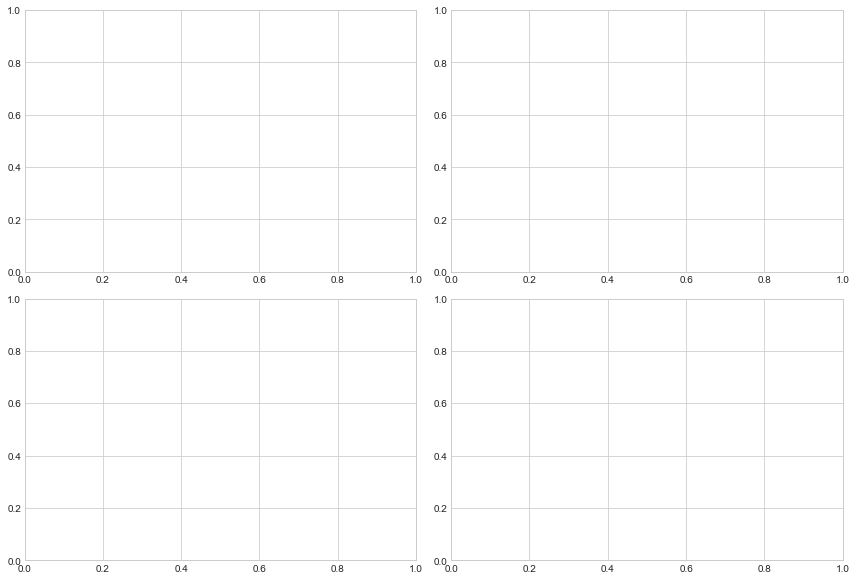

In [2]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

In [44]:
excluded_defects = [] # ["As_Te",]
#                     "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd"]

defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    return ef, hole_conc, electron_conc, low_temp_conc

def objective_func(x, anneal_temp):
    [muCd, muCu, muAs, muCl] = x
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, muAs, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      anneal_temp)
#     return [ef, np.abs(1-np.sum(low_temp_conc[-4:])/1e16), np.abs(1-np.sum(low_temp_conc[-8:-4])/1e16)]
    return [ ef, np.abs(1e14 - np.sum(low_temp_conc[7:11])) ]

upper_bounds = [0, 0, 0, 0]
lower_bounds = [H_CdTe, -2.0, -2.0, -2.0]
constraints = [lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1],
               lambda x:  H_Cd3As2 - 3*x[0] - 2*x[2],
               lambda x:  H_CdCl2 - x[0] - 2*x[3] ]


anneal_temps = np.arange(400, 1205, 50)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
As_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
As_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)


x_init = np.array([-1, -0.2, -1, -1])
for i, ann_temp in enumerate(anneal_temps):
    
    obj_func = lambda x: objective_func(x, ann_temp)
    
    parametrization = ng.p.Array(init=x_init,
                                 lower=lower_bounds,
                                 upper=upper_bounds)
    for cons in constraints:
        parametrization.register_cheap_constraint(cons)
    opt = ng.optimizers.NGOpt(parametrization=parametrization,
                              budget=1000)
    
    opt.tell(ng.p.MultiobjectiveReference(), [5, 5])

    recommendation = opt.minimize(obj_func)
    
#     print(f' Step {i} | temp {ann_temp} |')
#     for param in sorted(opt.pareto_front(1, subset="hypervolume"), key=lambda p: p.losses[0]):
#         print(f"{param.value} with losses {param.losses}")

#     x1 = recommendation.value

    pareto_params = opt.pareto_front(1, subset="domain-covering") 
    x1 = pareto_params[0].value
    x_init[:] = x1
    
    Cd_chem_pots[i] = x1[0]
    Cu_chem_pots[i] = x1[1]
    As_chem_pots[i] = x1[2]
    Cl_chem_pots[i] = x1[3]
    
    print(f' Step {i} | temp {ann_temp} | params {x1}')
    print(f' -> Loss {pareto_params[0].losses}')
    
    chem_pots = [x1[0], 0, H_CdTe-x1[0], x1[1], x1[2], x1[3]]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[11:])
    Cl_concentrations[i] = np.sum(low_temp_conc[7:11])
    As_concentrations[i] = np.sum(low_temp_conc[6])
    

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt

 Step 0 | temp 400 | params [-1.15630999 -0.24781413 -1.22731659 -1.6177482 ]
 -> Loss [0.28736635 1.        ]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 1 | temp 450 | params [-1.05811569 -0.14635349 -0.41633096 -1.33160061]
 -> Loss [0.26804676 0.99999971]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 2 | temp 500 | params [-1.16870591 -0.25938314 -1.33757692 -1.50740532]
 -> Loss [0.22097222 0.99999998]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))


 Step 3 | temp 550 | params [-1.15719607 -0.24904006 -1.81371592 -1.44331801]
 -> Loss [0.20882658 0.99999836]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 4 | temp 600 | params [-1.16893342 -0.30697866 -1.87631057 -1.37174796]
 -> Loss [0.19972667 0.9999543 ]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 5 | temp 650 | params [-1.16953394 -0.35637001 -1.23396216 -1.36600401]
 -> Loss [0.19487638 0.99974192]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 6 | temp 700 | params [-1.16696026 -0.36113886 -0.61523192 -1.2371137 ]
 -> Loss [0.19415583 0.98846365]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 7 | temp 750 | params [-1.14527149 -0.52112418 -1.24356017 -1.50363329]
 -> Loss [0.19058815 0.99970586]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 8 | temp 800 | params [-1.16376517 -0.58537685 -1.13250197 -1.51121546]
 -> Loss [0.18371036 0.99922045]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 9 | temp 850 | params [-1.14966403 -0.67111961 -1.22337574 -1.31790916]
 -> Loss [0.18261916 0.97308617]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 10 | temp 900 | params [-1.15550652 -0.46501697 -1.6585736  -1.22613386]
 -> Loss [0.19495058 0.43679215]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 11 | temp 950 | params [-1.1616996  -0.59504253 -1.6198177  -1.23151445]
 -> Loss [0.18557149 0.35193479]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 12 | temp 1000 | params [-1.14379001 -0.7450197  -1.97264753 -1.4135626 ]
 -> Loss [0.17965148 0.88749329]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 13 | temp 1050 | params [-1.16656458 -0.83421096 -1.63446072 -1.28324378]
 -> Loss [0.17625513 0.37406605]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 14 | temp 1100 | params [-1.01847823 -0.47282622 -1.22782505 -1.41116441]
 -> Loss [0.21634357 0.00041537]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 15 | temp 1150 | params [-1.16956972 -0.86787176 -0.87357118 -1.31014585]
 -> Loss [0.18311801 0.0038934 ]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 16 | temp 1200 | params [-1.15625119 -0.80799933 -0.90534377 -1.40801148]
 -> Loss [0.18808559 0.00378002]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


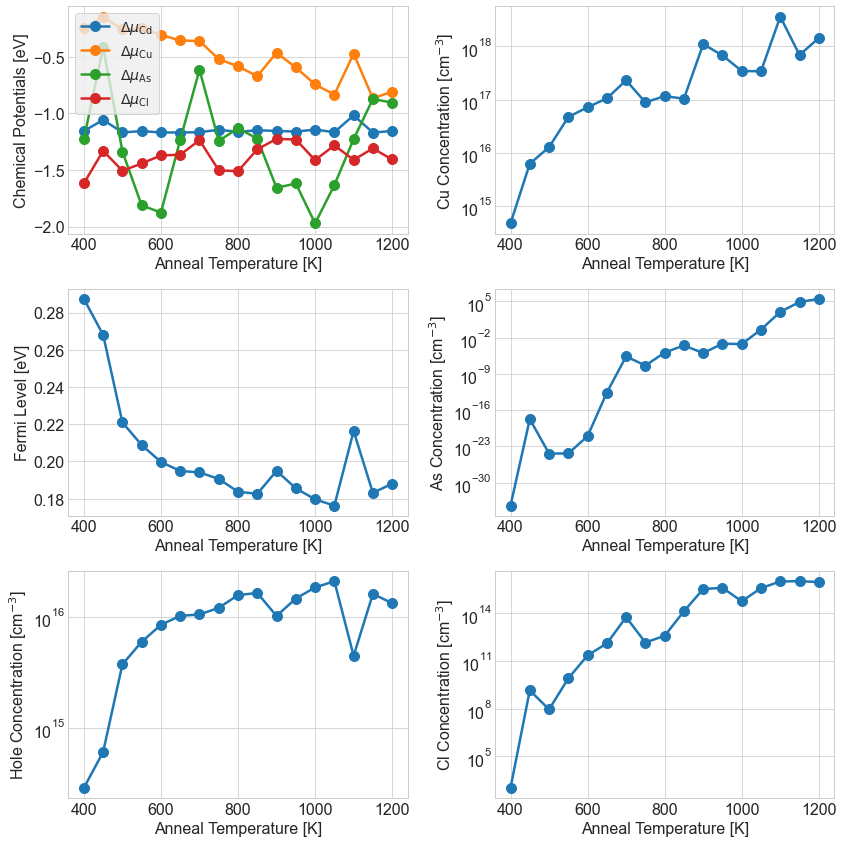

In [46]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, As_chem_pots, label=r'$\Delta \mu_\mathrm{As}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, As_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'As Concentration [cm$^{-3}$]')


axes[2][1].plot(anneal_temps, Cl_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][1].set_yscale('log')
axes[2][1].set_xlabel('Anneal Temperature [K]')
axes[2][1].set_ylabel(r'Cl Concentration [cm$^{-3}$]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

In [18]:
# print(sorted(ng.optimizers.registry.keys()))

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
excluded_defects = ["As_Te",]
#                     "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd"]

defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    return ef, hole_conc, electron_conc, low_temp_conc

def objective_func(x, anneal_temp):
    [muCu, muCl] = x
    muCd = H_CdTe
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      anneal_temp)
    return [ np.abs(np.log(np.sum(low_temp_conc[10:])/1e15)),
             np.abs(np.log(np.sum(low_temp_conc[6:10])/1e12)) ]

upper_bounds = [0, 0]
lower_bounds = [-2.0, -2.0]
constraints = [lambda x:  H_CuTe - x[0],
               lambda x:  H_CdCl2 - H_CdTe - 2*x[1] ]


anneal_temps = np.arange(400, 1205, 100)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)


x_init = np.array([-0.2, -1])
for i, ann_temp in enumerate(anneal_temps):
    
    obj_func = lambda x: objective_func(x, ann_temp)
    
    parametrization = ng.p.Array(init=x_init,
                                 lower=lower_bounds,
                                 upper=upper_bounds)
    for cons in constraints:
        parametrization.register_cheap_constraint(cons)
    opt = ng.optimizers.NGOpt(parametrization=parametrization,
                              budget=1000)
    
    opt.tell(ng.p.MultiobjectiveReference(), [1, 1])

    recommendation = opt.minimize(obj_func)
    
#     print(f' Step {i} | temp {ann_temp} |')
#     for param in sorted(opt.pareto_front(1, subset="hypervolume"), key=lambda p: p.losses[0]):
#         print(f"{param.value} with losses {param.losses}")

#     x1 = recommendation.value

    pareto_params = opt.pareto_front(1, subset="loss-covering") 
    x1 = pareto_params[0].value
    x_init[:] = x1
    
    Cu_chem_pots[i] = x1[0]
    Cl_chem_pots[i] = x1[1]
    
    print(f' Step {i} | temp {ann_temp} | params {x1}')
    print(f' -> Loss {pareto_params[0].losses}')
    
    chem_pots = [H_CdTe, 0, 0, x1[0], 0, x1[1]]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[10:])
    Cl_concentrations[i] = np.sum(low_temp_conc[6:10])
    

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))


 Step 0 | temp 400 | params [-0.25006908 -1.21582348]
 -> Loss [0.63732047 9.15741621]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:86: RuntimeWarning: overflow encountered in exp
  pred = lambda x: KT**(1.5) * self.pref_v * np.sqrt(x) / (1 + np.exp( (x - eta_Fv) ))


 Step 1 | temp 500 | params [-0.37130145 -1.21503442]
 -> Loss [0.99349794 3.56681073]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 2 | temp 600 | params [-0.58605339 -1.2280529 ]
 -> Loss [1.07612337 0.90142037]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 3 | temp 700 | params [-0.93190128 -1.24149978]
 -> Loss [0.01207244 0.00070159]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 4 | temp 800 | params [-1.10917493 -1.42300345]
 -> Loss [0.01777076 0.00105861]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 5 | temp 900 | params [-1.24624474 -1.65447327]
 -> Loss [0.00033223 0.24968772]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 6 | temp 1000 | params [-1.37779379 -1.84919701]
 -> Loss [0.04972828 0.00175574]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: BadLossWarning: Updating fitness with inf value
  warnings.warn(msg, e)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/optimization/base.py:146: LossTooLargeWarning: Clipping very high value inf in tell (rescale the cost function?).
  warnings.warn(msg, e)


 Step 7 | temp 1100 | params [-1.50723964 -1.99941531]
 -> Loss [0.12456281 0.66413887]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/nevergrad/parametrization/core.py:291: UserWarning: Lambda as constraint is not advised because it may not be picklable.
  warnings.warn("Lambda as constraint is not advised because it may not be picklable.")
/Users/dsommer/Dropbox/scratch/pycct/new_dev/defect_thermodynamics.py:85: RuntimeWarning: overflow encountered in exp
  nred = lambda x: KT**(1.5) * self.pref_c * np.sqrt(x) / (1 + np.exp( (x - eta_Fc) ))


 Step 8 | temp 1200 | params [-1.71068128 -1.99999962]
 -> Loss [0.51432844 2.65807786]


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


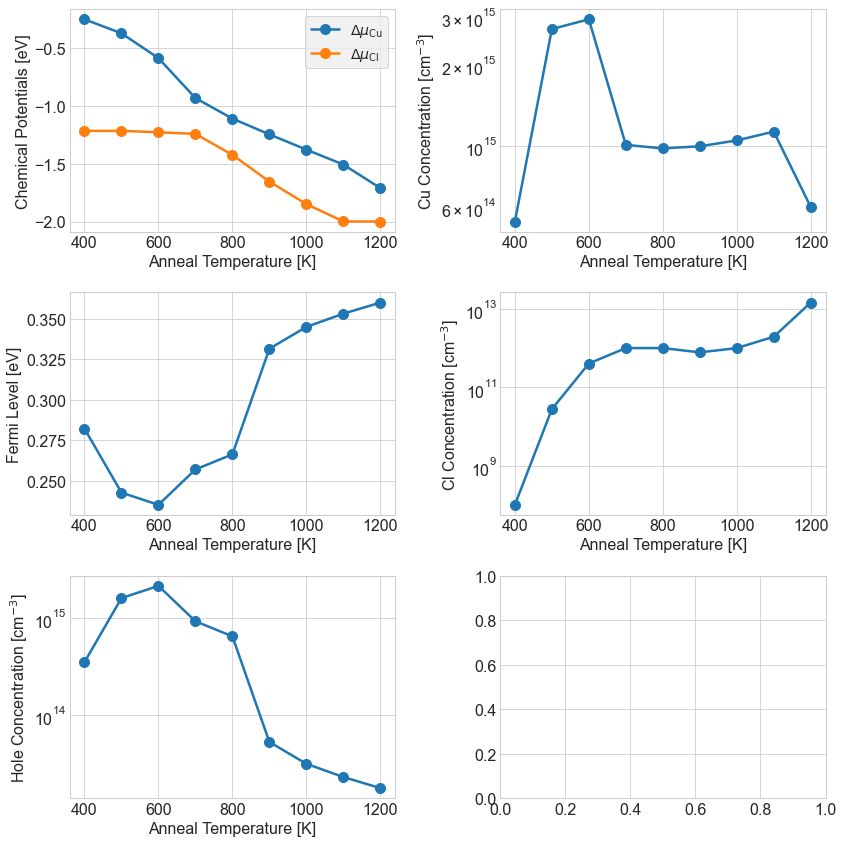

In [14]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, Cl_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Cl Concentration [cm$^{-3}$]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

In [77]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.algorithms.soo.nonconvex.pattern_search import PatternSearch
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.decomposition.asf import ASF
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool


class FermiDopants(ElementwiseProblem):
    def __init__(self, anneal_temp, **kwargs):
        
        self.anneal_temp = anneal_temp
        self.H_CdTe = -1.17
        self.H_CuTe = -0.25
        self.H_Cd3As2 = -0.46
        self.H_CdCl2 = -3.60
        
        upper_bounds = np.array([0, 0, 0])
        lower_bounds = np.array([self.H_CdTe, -5.0, -5.0])

        excluded_defects = ["As_Te",]
        self.defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                            excluded_defects=excluded_defects)

        super().__init__(n_var=3, n_obj=2, n_constr=3, xl=lower_bounds, xu=upper_bounds, **kwargs)
        
    def _evaluate(self, x, out, *args, **kwargs):
        chem_pots = [x[0], 0, self.H_CdTe-x[0], x[1], 0, x[2]]
        final_temperature = 300
    
        ef, hole_conc, electron_conc, low_temp_conc = self.annealed_quantities(chem_pots, 
                                                                               final_temperature, 
                                                                               self.anneal_temp)
        
        g1 = -(self.H_CuTe - (self.H_CdTe-x[0]) - x[1])
        g2 = -(self.H_CdCl2 - x[0] - 2*x[2])
        g3 = np.log( 1e16 / np.sum(low_temp_conc[9:13]) )
        g4 = np.log( 1e16 / np.sum(low_temp_conc[13:]) )
        g5 = - np.log( 1e19 / np.sum(low_temp_conc[13:]) )
       
        # f1 = ef
        # f2 = np.abs(np.log(np.sum(low_temp_conc[6:10])/1e12))
        
        f1 = ef
        f2 = np.abs( np.log( 1e16 / np.sum(low_temp_conc[13:]) )) / 10
        f3 = np.abs( np.log( 1e12 / np.sum(low_temp_conc[9:13]) )) / 10
                           
        out['F'] = [f1, f3]
        out['G'] = [g1, g2, g4]
        
    def annealed_quantities(self, chem_pots, final_temperature, anneal_temp):
        ef_anneal = self.defect_thermo.solve_for_fermi_energy(chem_pots,
                                                              anneal_temp)
        high_temp_conc = self.defect_thermo.defect_concentrations(chem_pots, 
                                                                  ef_anneal,
                                                                  anneal_temp)
        ef = self.defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, 
                                                                       final_temperature, 
                                                                       anneal_temp)
        hole_conc, electron_conc = self.defect_thermo.charge_carriers(ef,
                                                                      final_temperature)
        low_temp_conc = self.defect_thermo.redistribute_defect_charge_states(high_temp_conc, 
                                                                             ef, 
                                                                             final_temperature)

        return ef, hole_conc, electron_conc, low_temp_conc
    
    
n_threads = 4
pool = ThreadPool(n_threads)

algorithm = AGEMOEA(pop_size=100, return_least_infeasible=False)
# algorithm = PatternSearch(return_least_infeasible=True)
termination = get_termination("n_gen", 25)


anneal_temps = np.arange(500, 1205, 100)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)

for i, ann_temp in enumerate(anneal_temps):

    problem = FermiDopants(anneal_temp=ann_temp,
                           runner=pool.starmap, 
                           func_eval=starmap_parallelized_eval)
    
    res = minimize(problem,
                   algorithm,
                   termination,
#                    seed=1,
                   save_history=True,
                   verbose=True)
    
    X = res.X
    F = res.F
#     print(res.X)
#     print(res.F)
    
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    decomp = ASF()
    weights = np.array([0.2, 0.8])
    j = decomp.do(nF, 1/weights).argmin()

    Cd_chem_pots[i] = X[j,0]
    Cu_chem_pots[i] = X[j,1]
    Cl_chem_pots[i] = X[j,2]
    
    print(f' Step {i} | temp {ann_temp} | params {X[j]}')
    print(f' -> Loss {F[j]}')
    
    chem_pots = [X[j,0], 0, H_CdTe-X[j,0], X[j,1], 0, X[j,2]]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = problem.annealed_quantities(chem_pots, 
                                                                              final_temperature, 
                                                                              ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[13:])
    Cl_concentrations[i] = np.sum(low_temp_conc[9:13])


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.549096363 |  5.37735E+01 |       1 |            - |            -


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_val = np.iinfo(np.int).max


    2 |     200 |  0.00000E+00 |  1.75664E+01 |       1 |  3.912700298 |        ideal
    3 |     300 |  0.00000E+00 |  4.906861691 |       2 |  1.000000000 |        ideal


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:158: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  selected = np.zeros(m, dtype=np.bool)


    4 |     400 |  0.00000E+00 |  2.195318007 |       3 |  0.002095532 |            f
    5 |     500 |  0.00000E+00 |  1.017319896 |       2 |  6.35506E+02 |        ideal
    6 |     600 |  0.00000E+00 |  0.147195876 |       6 |  0.743932169 |        ideal
    7 |     700 |  0.00000E+00 |  0.002326157 |       6 |  0.158467698 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      10 |  0.059867502 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |      11 |  0.078386921 |            f
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      12 |  0.041374068 |        ideal
   11 |    1100 |  0.00000E+00 |  0.00000E+00 |       7 |  0.002687838 |        nadir
   12 |    1200 |  0.00000E+00 |  0.00000E+00 |       8 |  0.043011383 |            f
   13 |    1300 |  0.00000E+00 |  0.00000E+00 |      10 |  0.013542879 |            f
   14 |    1400 |  0.00000E+00 |  0.00000E+00 |      12 |  0.465571442 |        nadir
   15 |    1500 |  0.00000E+00 |  0.00000E+00 |      1

   12 |    1200 |  0.00000E+00 |  0.00000E+00 |       6 |  0.005437956 |        ideal
   13 |    1300 |  0.00000E+00 |  0.00000E+00 |       6 |  0.00000E+00 |            f
   14 |    1400 |  0.00000E+00 |  0.00000E+00 |       8 |  0.014905853 |        nadir
   15 |    1500 |  0.00000E+00 |  0.00000E+00 |       8 |  0.003688375 |        ideal
   16 |    1600 |  0.00000E+00 |  0.00000E+00 |       9 |  0.007982419 |        nadir
   17 |    1700 |  0.00000E+00 |  0.00000E+00 |      12 |  0.025645389 |            f
   18 |    1800 |  0.00000E+00 |  0.00000E+00 |      12 |  0.690190347 |        nadir
   19 |    1900 |  0.00000E+00 |  0.00000E+00 |      11 |  0.009547235 |            f
   20 |    2000 |  0.00000E+00 |  0.00000E+00 |      14 |  0.000778939 |            f
   21 |    2100 |  0.00000E+00 |  0.00000E+00 |      13 |  0.004727148 |            f
   22 |    2200 |  0.00000E+00 |  0.00000E+00 |      18 |  0.086535303 |        nadir
   23 |    2300 |  0.00000E+00 |  0.00000E+00 |      1

   20 |    2000 |  0.00000E+00 |  0.00000E+00 |       9 |  0.003528884 |            f
   21 |    2100 |  0.00000E+00 |  0.00000E+00 |      10 |  1.98399E+01 |        nadir
   22 |    2200 |  0.00000E+00 |  0.00000E+00 |      12 |  1.334216288 |        nadir
   23 |    2300 |  0.00000E+00 |  0.00000E+00 |      15 |  0.384695172 |        nadir
   24 |    2400 |  0.00000E+00 |  0.00000E+00 |       8 |  0.085299225 |        nadir
   25 |    2500 |  0.00000E+00 |  0.00000E+00 |       4 |  0.004806394 |        nadir
 Step 6 | temp 1100 | params [-1.16998094 -1.2547982  -2.09820821]
 -> Loss [1.44559217e-01 4.10605731e-05]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.27788E+01 |       2 |            - |            -
    2 |     200 |  0.00000E+00 |  0.910607280 |       5 |  0.144133174 |        ideal
    3 |     300 |  0.00000E+00 |  0.00000E+00 |       6 |  0.052802475 |        ideal
    4 |     400 |  0.00000E+00 |

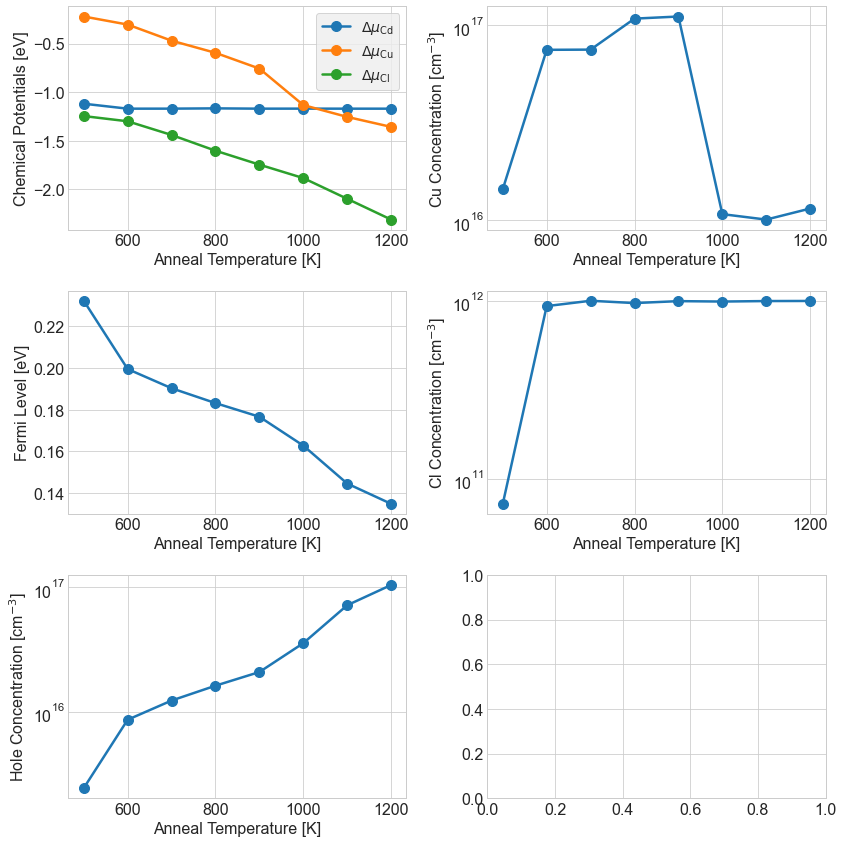

In [78]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, Cl_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Cl Concentration [cm$^{-3}$]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

At least one feasible solution in Generation 0 after 100 evaluations.
Whole population feasible in Generation 1 after 200 evaluations.


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


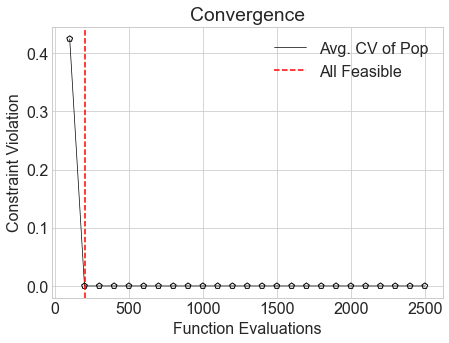

In [73]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

hist = res.history
for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Constraint Violation")
plt.legend()
plt.show()
plt.close()

from pymoo.util.running_metric import RunningMetric

running = RunningMetric(delta_gen=10,
                        n_plots=5,
                        only_if_n_plots=True,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.notify(algorithm)


In [64]:
res.F

array([[0.18271195, 0.37835497],
       [0.24057209, 0.19430237],
       [0.24158435, 0.19134093],
       [0.24184918, 0.1867347 ],
       [0.20492925, 0.20387886],
       [0.24158444, 0.18943686],
       [0.19120352, 0.27408199],
       [0.18326267, 0.34328006],
       [0.20809594, 0.20305239],
       [0.18805081, 0.29697671],
       [0.1911721 , 0.27410291],
       [0.2414328 , 0.19173799],
       [0.18266138, 0.47656677],
       [0.20221198, 0.20992816],
       [0.18274777, 0.36006251],
       [0.2097045 , 0.19782416],
       [0.19568508, 0.26586113],
       [0.1989384 , 0.25162099],
       [0.24168622, 0.18825993],
       [0.20358869, 0.20898135],
       [0.18552051, 0.33322906],
       [0.19021798, 0.27977744],
       [0.18263297, 0.67182592],
       [0.1866162 , 0.31783251],
       [0.1990166 , 0.2472887 ],
       [0.18752275, 0.3003852 ],
       [0.20209686, 0.23436716],
       [0.18268853, 0.38032232],
       [0.18410851, 0.33898731],
       [0.18634699, 0.32021552],
       [0.

In [60]:
X = res.X
F = res.F
#     print(res.X)
#     print(res.F)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights = np.array([0.01, 0.01, 0.98])
j = decomp.do(nF, 1/weights).argmin()

print(X[j])
print(F[j])

[-0.87629642 -0.06303653 -1.37212222]
[0.26481642 0.59350791 0.20581592]


In [52]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.algorithms.soo.nonconvex.pattern_search import PatternSearch
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.decomposition.asf import ASF
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool


class FermiDopants(ElementwiseProblem):
    def __init__(self, anneal_temp, **kwargs):
        
        self.anneal_temp = anneal_temp
        self.H_CdTe = -1.17
        self.H_CuTe = -0.25
        self.H_Cd3As2 = -0.46
        self.H_CdCl2 = -3.60
        
        upper_bounds = np.array([0, 0])
        lower_bounds = np.array([self.H_CdTe, -2.0])

        excluded_defects = [#"V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                            "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                            "As_Te", 
                            "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                            "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]
        self.defect_thermo = DefectThermodynamics.from_json('params_CdTe_Wei_FS.json',
                                                            excluded_defects=excluded_defects)

        super().__init__(n_var=2, n_obj=2, n_constr=2, xl=lower_bounds, xu=upper_bounds, **kwargs)
        
    def _evaluate(self, x, out, *args, **kwargs):
        chem_pots = [x[0], 0, self.H_CdTe-x[0], x[1], 0, 0]
        final_temperature = 300
    
        ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = self.annealed_quantities(chem_pots, 
                                                                                   final_temperature, 
                                                                                   self.anneal_temp)

        g1 = -(self.H_CuTe - (self.H_CdTe-x[0]) - x[1])
#         g2 = -(self.H_CdCl2 - x[0] - 2*x[2])
        g3 = np.log( 1e16 / np.sum(low_temp_conc[6:]) )
#         g4 = np.log( 1e16 / np.sum(low_temp_conc[13:]) )
#         g5 = - np.log( 1e19 / np.sum(low_temp_conc[13:]) )
       
        # f1 = ef
        # f2 = np.abs(np.log(np.sum(low_temp_conc[6:10])/1e12))
        
        f1 = ef
#         f2 = np.abs( np.log( 1e16 / np.sum(low_temp_conc[13:]) )) / 10
#         f3 = np.abs( np.log( 1e12 / np.sum(low_temp_conc[9:13]) )) / 10
        f4 = -np.log(total_lifetime)
                           
        out['F'] = [f1, f4]
        out['G'] = [g1, g3]
        
    def annealed_quantities(self, chem_pots, final_temperature, anneal_temp):
        ef_anneal = self.defect_thermo.solve_for_fermi_energy(chem_pots,
                                                              anneal_temp)
        high_temp_conc = self.defect_thermo.defect_concentrations(chem_pots, 
                                                                  ef_anneal,
                                                                  anneal_temp)
        ef = self.defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, 
                                                                       final_temperature, 
                                                                       anneal_temp)
        hole_conc, electron_conc = self.defect_thermo.charge_carriers(ef,
                                                                      final_temperature)
        low_temp_conc = self.defect_thermo.redistribute_defect_charge_states(high_temp_conc, 
                                                                             ef, 
                                                                             final_temperature)
        
        NCu_Cd = np.sum(low_temp_conc[6])
        NCu_int = np.sum(low_temp_conc[7])
    
        Bn = 2.55e-10
        Bp = 6.82e-10
        capture_rates = [Bn * NCu_Cd, Bp * NCu_int]
        total_lifetime = 1/np.sum(capture_rates)

        return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime
    
    
n_threads = 4
pool = ThreadPool(n_threads)

algorithm = AGEMOEA(pop_size=100, return_least_infeasible=True)
# algorithm = PatternSearch(return_least_infeasible=True)
termination = get_termination("n_gen", 10)


anneal_temps = np.arange(500, 1205, 50)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
lifetimes = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)

for i, ann_temp in enumerate(anneal_temps):

    problem = FermiDopants(anneal_temp=ann_temp,
                           runner=pool.starmap, 
                           func_eval=starmap_parallelized_eval)
    
    res = minimize(problem,
                   algorithm,
                   termination,
#                    seed=1,
                   save_history=True,
                   verbose=True)
    
    X = res.X
    F = res.F
#     print(res.X)
#     print(res.F)
    
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    decomp = ASF()
    weights = np.array([0.8, 0.2])
    j = decomp.do(nF, 1/weights).argmin()

    Cd_chem_pots[i] = X[j,0]
    Cu_chem_pots[i] = X[j,1]
    
    print(f' Step {i} | temp {ann_temp} | params {X[j]}')
    print(f' -> Loss {F[j]}')
    
    chem_pots = [X[j,0], 0, H_CdTe-X[j,0], X[j,1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = problem.annealed_quantities(chem_pots, 
                                                                                  final_temperature, 
                                                                                  ann_temp)
    efermis[i] = ef
    lifetimes[i] = total_lifetime
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[6:])


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_val = np.iinfo(np.int).max


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  2.06419E+01 |       1 |            - |            -
    2 |     200 |  0.00000E+00 |  7.047533554 |       1 |  0.00000E+00 |            f
    3 |     300 |  0.00000E+00 |  2.896989605 |       2 |  2.201093288 |        ideal


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:158: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  selected = np.zeros(m, dtype=np.bool)


    4 |     400 |  0.00000E+00 |  0.800769968 |       5 |  0.208026135 |        ideal
    5 |     500 |  0.00000E+00 |  0.035963483 |       5 |  0.182861050 |        ideal
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      10 |  0.060199611 |        ideal
    7 |     700 |  0.00000E+00 |  0.00000E+00 |       9 |  0.010173174 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |       8 |  0.081037470 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |       7 |  0.035003186 |        ideal
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      10 |  0.019126307 |        ideal
 Step 0 | temp 500 | params [-1.12359763 -0.23088317]
 -> Loss [ 0.23194571 15.01344044]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.62766E+01 |       2 |            - |            -
    2 |     200 |  0.00000E+00 |  4.719562425 |       4 |  0.044759145 |        ideal
    3 |     300 |  0.00000E+00 |  1.548583263 |    

    2 |     200 |  0.00000E+00 |  0.153659197 |      11 |  0.111690592 |        ideal
    3 |     300 |  0.00000E+00 |  0.00000E+00 |      15 |  0.021901144 |            f
    4 |     400 |  0.00000E+00 |  0.00000E+00 |      20 |  0.036527875 |        ideal
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      35 |  0.004650978 |        ideal
    6 |     600 |  0.00000E+00 |  0.00000E+00 |      53 |  0.020582375 |        nadir
    7 |     700 |  0.00000E+00 |  0.00000E+00 |      79 |  0.028026267 |        nadir
    8 |     800 |  0.00000E+00 |  0.00000E+00 |     100 |  0.002738519 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001550932 |            f
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001142226 |            f
 Step 7 | temp 850 | params [-1.16998552 -0.82604534]
 -> Loss [ 0.18705248 15.95323615]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  5.154022263 |    

    2 |     200 |  0.00000E+00 |  0.00000E+00 |      16 |  0.006679640 |        ideal
    3 |     300 |  0.00000E+00 |  0.00000E+00 |      29 |  0.003993656 |        ideal
    4 |     400 |  0.00000E+00 |  0.00000E+00 |      46 |  0.034895895 |        ideal
    5 |     500 |  0.00000E+00 |  0.00000E+00 |      74 |  0.003785099 |        ideal
    6 |     600 |  0.00000E+00 |  0.00000E+00 |     100 |  0.022086773 |        nadir
    7 |     700 |  0.00000E+00 |  0.00000E+00 |     100 |  0.007996102 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |     100 |  0.002193211 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |     100 |  0.002324372 |            f
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |     100 |  0.001393786 |            f
 Step 14 | temp 1200 | params [-1.13851836 -0.97698418]
 -> Loss [ 0.21913658 18.51689308]


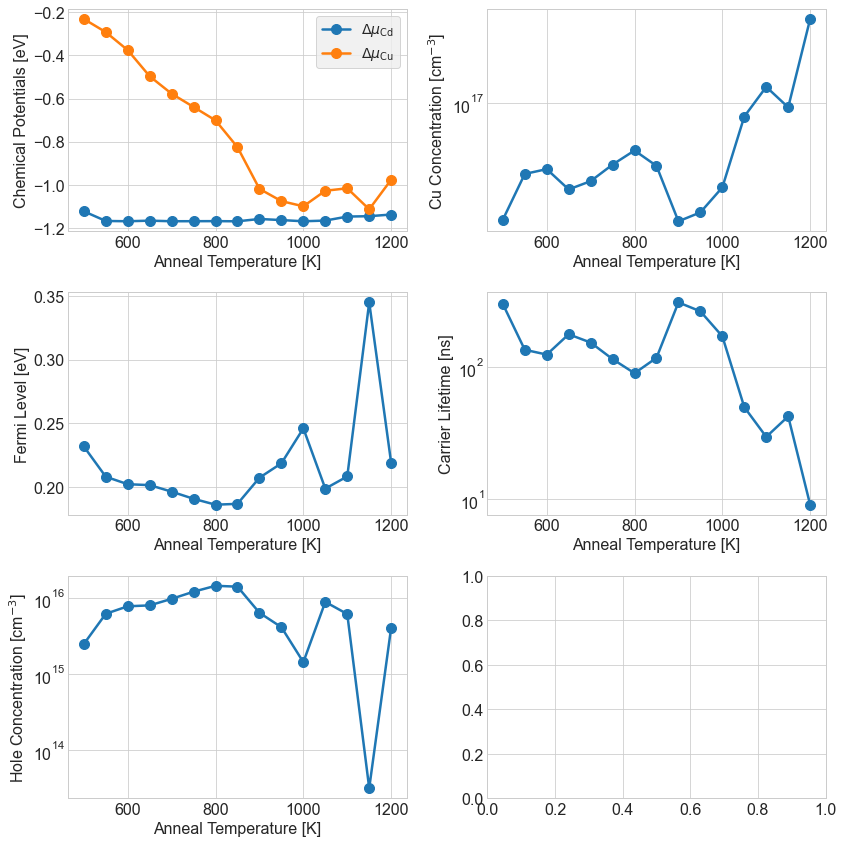

In [53]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()